In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd

In [102]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:

class Uni_RNN(nn.Module):
    #hidden1: chatpgt 512-384
    #hidden2: chatpgt 256-128
    def __init__(self,embedding_model,hidden1,hidden2):
        super().__init__()
        self.embedding_dim=768

        bert= BertModel.from_pretrained(embedding_model)
        self.embedding_vector = bert.embeddings.word_embeddings.weight
        self.LSTM= nn.LSTM(self.embedding_dim,hidden1, batch_first=True)
        self.LSTM2= nn.LSTM(hidden1,hidden2, batch_first=True)
        self.fc_pinicial= nn.Linear(hidden2,1)
        self.fc_cap = nn.Linear(hidden2, 4)
        self.fc_pfinal = nn.Linear(hidden2, 4)

    def forward(self,data,inferencia=False):

        data= self.embedding_vector[data]
        data, _=self.LSTM(data)
        data, _=self.LSTM2(data)
        final= data

        output_cap= self.fc_cap(final)
        output_punt_inicial=self.fc_pinicial(final)
        output_punt_final=self.fc_pfinal(final)

        if inferencia:
            output_punt_final=torch.softmax(self.fc_pfinal(final),dim=-1)
            output_punt_final=torch.argmax(output_punt_final,dim=-1)
            output_cap=torch.softmax(self.fc_cap(final),dim=-1)
            output_cap=torch.argmax(output_cap,dim=-1)
            output_punt_inicial= torch.sigmoid(self.fc_pinicial(final))

        return output_punt_inicial,output_punt_final,output_cap


In [104]:
from torch.utils.data import Dataset
path="/content/drive/MyDrive/Datos_AA2/"

class dataset_subtitulos(Dataset):
    def __init__(self, path, cantidad_instancias=None):
        data = pd.read_parquet(
            path,
            columns=[
                "instancia_id",
                "token_id",
                "punt_inicial",
                "pfinal",
                "capitalizacion",
            ],
        )
        if cantidad_instancias != None:
          data=data[data["instancia_id"]<=cantidad_instancias]

        self.instancias = [g for _, g in data.groupby("instancia_id")]


    def __len__(self):
        return len(self.instancias)

    def __getitem__(self, idx):
        df_instancia=self.instancias[idx]
        features= torch.tensor(df_instancia["token_id"].values)
        target = torch.tensor(df_instancia[["punt_inicial","pfinal","capitalizacion"]].values,dtype=torch.long)
        return features, target

    def get_instancia(self,idx):
        df_instancia=self.instancias[idx]
        return list(df_instancia["token_id"].values)

sub_data = dataset_subtitulos(path+"datos_modelo.parquet",1000)



#data_loader

In [105]:
#visualizacion del dataset
sub_data[2] #PINICIAL Pfinal  cap

(tensor([10192, 10321, 13386, 10192, 12994, 21267, 10216, 24256]),
 tensor([[0, 2, 1],
         [0, 0, 1],
         [0, 2, 1],
         [0, 0, 1],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 2, 0]]))

In [106]:
#Creamos Dataloaders
train_size=int(len(sub_data)*0.8)
valid_size=len(sub_data)-train_size

train_dataset, valid_dataset = random_split(sub_data,[train_size,valid_size])

data_loader_train=DataLoader(train_dataset,batch_size=None,shuffle=True)
data_loader_valid=DataLoader(valid_dataset,batch_size=None,shuffle=False)

In [107]:
for data, target in data_loader_train:
    break
model=Uni_RNN("bert-base-multilingual-cased",512,256)
bert= BertModel.from_pretrained("bert-base-multilingual-cased")
embedding_vector = bert.embeddings.word_embeddings.weight

In [108]:
ce = nn.CrossEntropyLoss()
print(data.shape,target.shape)
o1,o2,o3 = model.forward(data)
print(o1.shape,o2.shape,o3.shape)
target_cap=target[:,-1]

print(target_cap.shape)
ce(o3,target_cap)  #Target cap  batch size x t_len
#o1 batch size x tlen x clases
#o1.permute(0,2,1) tiene dimensiones batch_size x clases x tlen

torch.Size([36]) torch.Size([36, 3])
torch.Size([36, 1]) torch.Size([36, 4]) torch.Size([36, 4])
torch.Size([36])


tensor(1.3681, grad_fn=<NllLossBackward0>)

In [109]:
bce=nn.BCEWithLogitsLoss()
target_pinicial=target[:,0].float()
print(o1.shape,target_pinicial.shape)
bce(o1.squeeze(1),target_pinicial)


torch.Size([36, 1]) torch.Size([36])


tensor(0.7016, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [110]:
#TRAINING LOOP
#128,64 se ve un overfit claro con 5k datos 5 epochs
model=Uni_RNN("bert-base-multilingual-cased",32,16)
bce=nn.BCEWithLogitsLoss()
ce = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(),lr=0.001)


verbose=False
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

model=model.to(device)
num_epoch=5
train_losses =[]
train_losses_cap=[]
train_losses_pinicial=[]
train_losses_pfinal=[]


val_losses=[]
val_losses_cap=[]
val_losses_pinicial=[]
val_losses_pfinal=[]



for epoch in range(num_epoch):
    model.train()
    running_loss=0.0
    running_loss_cap=0.0
    running_loss_pinicial=0.0
    running_loss_pfinal=0.0
    i=0
    for data, target in data_loader_train:
        if verbose:
          i+=1
          print(f"procesando {i/len(data_loader_train)*100}% del train")

        #Computamos el output y damos formato
        optimizer.zero_grad()
        data=data.to(device)
        target=target.to(device)
        pinicial_target=target[:,0].float()
        pfinal_target=target[:,1]
        cap_target=target[:,2]

        output_punt_inicial,output_punt_final,output_cap=model(data)

        output_punt_inicial=output_punt_inicial.squeeze(1)

        #calculamos la loss
        loss_cap= ce(output_cap,cap_target)
        loss_pinicial=bce(output_punt_inicial,pinicial_target)
        loss_pfinal=ce(output_punt_final,pfinal_target)

        loss=loss_cap+loss_pinicial+loss_pfinal #esto es todo un tensor

        #backpropagation
        loss.backward()
        optimizer.step()

        #guardamos datos para despues
        running_loss += loss.item()
        running_loss_cap+=loss_cap.item()
        running_loss_pinicial+=loss_pinicial.item()
        running_loss_pfinal+=loss_pfinal.item()

    train_loss = running_loss / len(data_loader_train)
    train_loss_cap= running_loss_cap / len(data_loader_train)
    train_loss_pinicial =running_loss_pinicial / len(data_loader_train)
    train_loss_pfinal = running_loss_pfinal / len(data_loader_train)

    train_losses.append(train_loss)
    train_losses_cap.append(train_loss_cap)
    train_losses_pinicial.append(train_loss_pinicial)
    train_losses_pfinal.append(train_loss_pfinal)

    model.eval()
    running_loss=0.0
    running_loss_cap=0.0
    running_loss_pinicial=0.0
    running_loss_pfinal=0.0
    with torch.inference_mode():

        for data, target in data_loader_valid:

            data=data.to(device)
            target=target.to(device)


            pinicial_target=target[:,0].float()
            pfinal_target=target[:,1]
            cap_target=target[:,2]

            output_punt_inicial,output_punt_final,output_cap=model(data)

            output_punt_inicial=output_punt_inicial.squeeze(1)

            loss_cap= ce(output_cap,cap_target)
            loss_pinicial=bce(output_punt_inicial,pinicial_target)
            loss_pfinal=ce(output_punt_final,pfinal_target)



            loss=loss_cap+loss_pinicial+loss_pfinal #esto es todo un tensor
            running_loss += loss.item()
            running_loss_cap+=loss_cap.item()
            running_loss_pinicial+=loss_pinicial.item()
            running_loss_pfinal+=loss_pfinal.item()


        val_loss=running_loss / len(data_loader_valid)
        val_loss_cap= running_loss_cap / len(data_loader_valid)
        val_loss_pinicial =running_loss_pinicial / len(data_loader_valid)
        val_loss_pfinal = running_loss_pfinal / len(data_loader_valid)

        val_losses.append(val_loss)
        val_losses_cap.append(train_loss_cap)
        val_losses_pinicial.append(train_loss_pinicial)
        val_losses_pfinal.append(train_loss_pfinal)


    print(f"Epoch {epoch+1}/{num_epoch} -Train loss: {train_loss} - Val loss {val_loss}")
    print(f"Epoch {epoch+1}/{num_epoch} -Train cap loss: {train_loss_cap} - Val cap loss {val_loss_cap}")
    print(f"Epoch {epoch+1}/{num_epoch} -Train cap loss: {train_loss_pinicial} - Val pinicial loss {val_loss_pinicial}")
    print(f"Epoch {epoch+1}/{num_epoch} -Train cap loss: {train_loss_pfinal} - Val pfinal loss {val_loss_pfinal}")
    print("\n")



Device: cuda
Epoch 1/5 -Train loss: 1.5433172285556793 - Val loss 1.3048656824231148
Epoch 1/5 -Train cap loss: 0.6443119062483311 - Val cap loss 0.5273302946984768
Epoch 1/5 -Train cap loss: 0.18510433532530443 - Val pinicial loss 0.14317328937351703
Epoch 1/5 -Train cap loss: 0.7139009865932167 - Val pfinal loss 0.6343621009588242


Epoch 2/5 -Train loss: 1.1036090697348118 - Val loss 1.1555312816798686
Epoch 2/5 -Train cap loss: 0.42536099076271056 - Val cap loss 0.43973170418292284
Epoch 2/5 -Train cap loss: 0.13150646502850577 - Val pinicial loss 0.1295860883500427
Epoch 2/5 -Train cap loss: 0.546741615794599 - Val pfinal loss 0.586213492769748


Epoch 3/5 -Train loss: 0.8856560066528618 - Val loss 1.131838810145855
Epoch 3/5 -Train cap loss: 0.29330169001594186 - Val cap loss 0.43440839428454636
Epoch 3/5 -Train cap loss: 0.11150967550463975 - Val pinicial loss 0.1144723445456475
Epoch 3/5 -Train cap loss: 0.480844641905278 - Val pfinal loss 0.5829580697976052


Epoch 4/5 -Train 

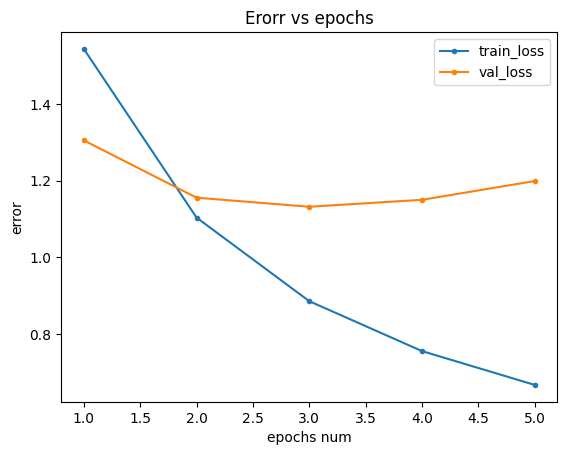

In [111]:
import matplotlib.pyplot as plt
epochs_range=range(1,num_epoch+1)
plt.plot(epochs_range,train_losses,marker=".",label="train_loss")
plt.plot(epochs_range,val_losses,marker=".",label="val_loss")
plt.title("Erorr vs epochs")
plt.xlabel("epochs num")
plt.ylabel("error")
plt.legend()


In [112]:

def decodificador(data,model):
  """Con los tokens del input y el modelo podemos reconstruir el texto """

  tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
  tokens=tokenizer.convert_ids_to_tokens(data)
  texto_salida=""
  pinicial, pfinal , cap= model(data,inferencia=True) #listas que me dicen que poner

  palabras_tokenizadas=[]
  i=0
  palabra=""
  while i <len(tokens):

    if pinicial[i]<=0.5:
      apertura=""
    else:
      apertura="¿"

    if pfinal[i]==0:
      cierre=""
    elif pfinal[i]==1:
      cierre="?"
    elif pfinal[i]==2:
      cierre="."
    elif pfinal[i]==3:
      cierre=","

    if tokens[i][:2]=="##":
      palabra+=apertura+tokens[i][2:]+cierre
    else:
      if cap[i]==1:
        token_procesado=tokens[i][0].upper()+tokens[i][1:]

      elif cap[i]==3:
          token_procesado=tokens[i].upper()

      elif cap[i]==2:
          token_procesado=""
          for j in range(tokens[i]):
            if j % 2 == 0:
              token_procesado+=tokens[i][j]
            else:
              token_procesado+=tokens[i][j].upper()

      elif cap[i] ==0:
        token_procesado=tokens[i]

      palabra+=apertura+token_procesado+cierre


    if i != len(tokens)-1 and tokens[i+1][:2]!="##": #si el proximo token no es decontinuacion termine la palabra
      palabras_tokenizadas.append(palabra)
      palabra=""

    elif i == len(tokens)-1:
      palabras_tokenizadas.append(palabra)
    i+=1


  texto_final =""
  for i in range(len(palabras_tokenizadas)):

    if i == 0:
      texto_final+=palabras_tokenizadas[i]
    else:
      texto_final+=" "
      texto_final+=palabras_tokenizadas[i]

  return texto_final

In [113]:
data , target = sub_data[3]

model(data,inferencia=True)

(tensor([[0.1731],
         [0.0061],
         [0.0079],
         [0.0010],
         [0.0039],
         [0.0021],
         [0.0425],
         [0.0023],
         [0.0010],
         [0.0031],
         [0.0021]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2], device='cuda:0'),
 tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0'))

In [114]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
tokens=tokenizer.convert_ids_to_tokens(data)
print(tokens)

['tiene', 'el', 'cu', '##ello', 'rot', '##o', 'el', 'ce', '##rebro', 'no', 'sirve']


In [116]:
decodificador(data,model)

'Tiene el cuello roto. El cerebro no sirve.'